# Germany Traffic Sign Classifier Project

        

---
## Import functions

In [130]:
%matplotlib inline
import pickle
import matplotlib
import os
import sys
import random
import cv2
import csv
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
from random import randint
from tensorflow.contrib.layers import flatten


## Load Data

In [156]:
# generate path string to current directory:
cwd = os.getcwd()

# TODO: Fill this in based on where you saved the training and testing data

training_file = cwd + '/Dataset/train.p'
validation_file= cwd + '/Dataset/valid.p'
testing_file = cwd + '/Dataset/test.p'


try:
   
    with open(training_file, mode='rb') as f:
        train = pickle.load(f)
    with open(validation_file, mode='rb') as f:
        valid = pickle.load(f)
    with open(testing_file, mode='rb') as f:
        test = pickle.load(f)

    
    X_train, y_train = train['features'], train['labels']
    X_valid, y_valid = valid['features'], valid['labels']

    # combine validation data into training data:
    X_train = np.concatenate((X_train,X_valid),axis=0)
    y_train = np.concatenate((y_train,y_valid),axis=0)
        
    # split test data:
    X_test, y_test = test['features'], test['labels']
    # Stats on Data:
    classList, classIndices, classCount = np.unique(y_train, return_index = True, return_counts = True)
    print('Data Loaded')
    # Ensure data size is correct:
    assert(len(X_train) == len(y_train))
    assert(len(X_test) == len(y_test))
    print("Image Shape: {}".format(X_train[0].shape))
    print()
    print("Training Set:   {} samples".format(len(X_train)))
    print("Test Set:       {} samples".format(len(X_test)))
    print("Classes:        {}".format(classList.size))
    
    class_names=[]
    with open('signnames.csv', 'rt') as csvfile:
        reader = csv.DictReader(csvfile, delimiter=',')
        for row in reader:
            class_names.append((row['SignName']))
    
except Exception as E:
    print('Error load: ')
    print(E)
    print(E.with_traceback)

Data Loaded
Image Shape: (32, 32, 3)

Training Set:   39209 samples
Test Set:       12630 samples
Classes:        43


## Step 2: Preview data


Class 0, Speed limit (20km/h), 210 samples


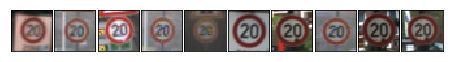

Class 1, Speed limit (30km/h), 2220 samples


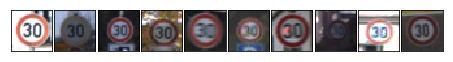

Class 2, Speed limit (50km/h), 2250 samples


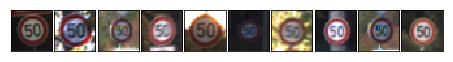

Class 3, Speed limit (60km/h), 1410 samples


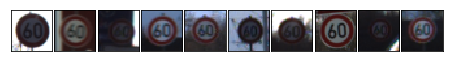

Class 4, Speed limit (70km/h), 1980 samples


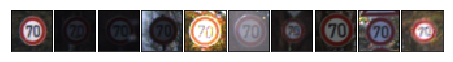

Class 5, Speed limit (80km/h), 1860 samples


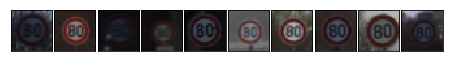

Class 6, End of speed limit (80km/h), 420 samples


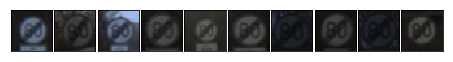

Class 7, Speed limit (100km/h), 1440 samples


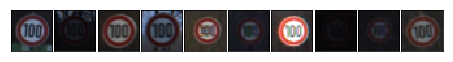

Class 8, Speed limit (120km/h), 1410 samples


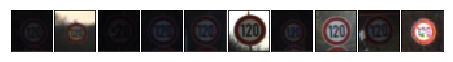

Class 9, No passing, 1470 samples


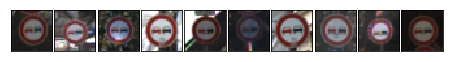

Class 10, No passing for vehicles over 3.5 metric tons, 2010 samples


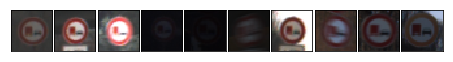

Class 11, Right-of-way at the next intersection, 1320 samples


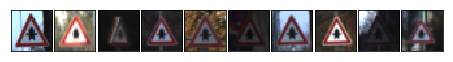

Class 12, Priority road, 2100 samples


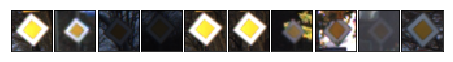

Class 13, Yield, 2160 samples


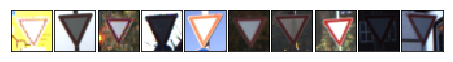

Class 14, Stop, 780 samples


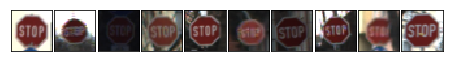

Class 15, No vehicles, 630 samples


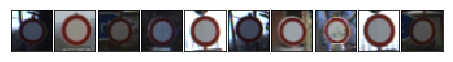

Class 16, Vehicles over 3.5 metric tons prohibited, 420 samples


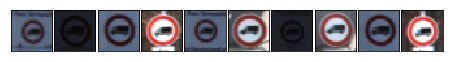

Class 17, No entry, 1110 samples


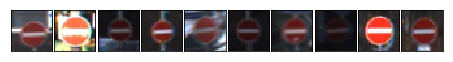

Class 18, General caution, 1200 samples


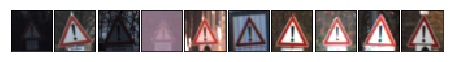

Class 19, Dangerous curve to the left, 210 samples


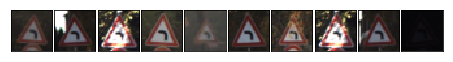

Class 20, Dangerous curve to the right, 360 samples


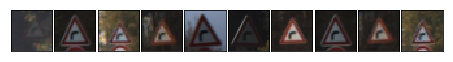

Class 21, Double curve, 330 samples


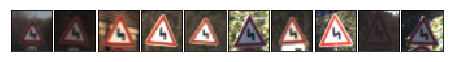

Class 22, Bumpy road, 390 samples


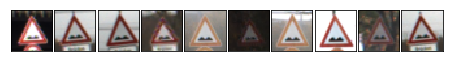

Class 23, Slippery road, 510 samples


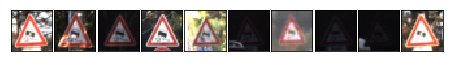

Class 24, Road narrows on the right, 270 samples


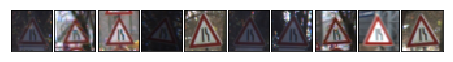

Class 25, Road work, 1500 samples


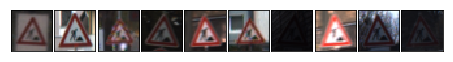

Class 26, Traffic signals, 600 samples


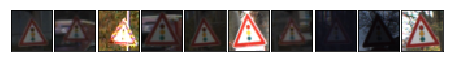

Class 27, Pedestrians, 240 samples


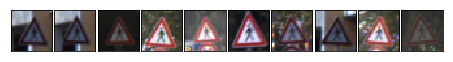

Class 28, Children crossing, 540 samples


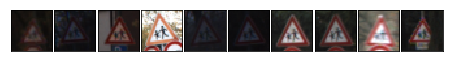

Class 29, Bicycles crossing, 270 samples


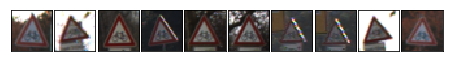

Class 30, Beware of ice/snow, 450 samples


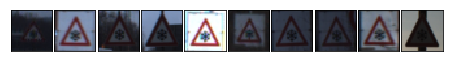

Class 31, Wild animals crossing, 780 samples


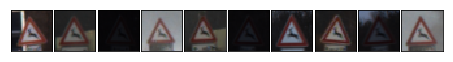

Class 32, End of all speed and passing limits, 240 samples


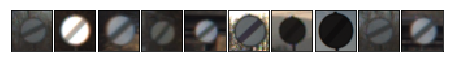

Class 33, Turn right ahead, 689 samples


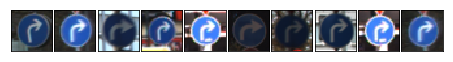

Class 34, Turn left ahead, 420 samples


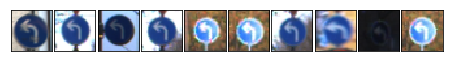

Class 35, Ahead only, 1200 samples


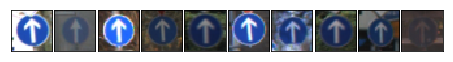

Class 36, Go straight or right, 390 samples


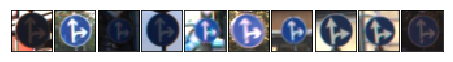

Class 37, Go straight or left, 210 samples


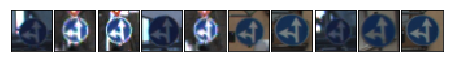

Class 38, Keep right, 2070 samples


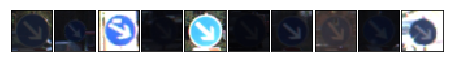

Class 39, Keep left, 300 samples


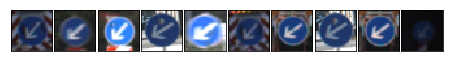

Class 40, Roundabout mandatory, 360 samples


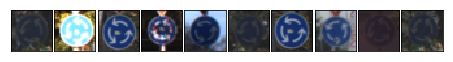

Class 41, End of no passing, 240 samples


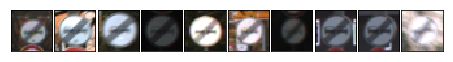

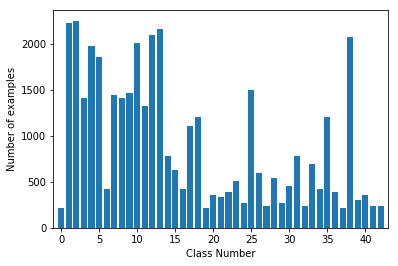

In [158]:
def preview(Data,Targets,classes):
    idxArray = np.arange(len(y_train))
    for c in classes:
        # indices of train examples that are of class c:
        idxs = idxArray[y_train==c]
        print("Class {:1d}, {}, {} samples".format(c, class_names[c], len(idxs)))
        # randomly sample 10 indices:
        random_indices = random.sample(idxs.tolist(), 10)
        # prepare figure:
        fig = plt.figure(figsize = (6, 1))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
        for i in range(10):
            axis = fig.add_subplot(1, 10, i + 1, xticks=[], yticks=[])
            if Data.shape[3]==3:
                axis.imshow(Data[random_indices[i]])
            else:
                temp = (Data[random_indices[i]] * 255.).astype(np.uint8)
                axis.imshow(Data[random_indices[i]].squeeze(),cmap='gray')
                pass
        plt.show()


clist = range(0,42);
preview(X_train,y_train,clist)
plt.bar( np.arange( classList.size ), classCount, align='center' )
plt.xlabel('Class Number')
plt.ylabel('Number of examples')
plt.xlim([-1, classList.size])
plt.show()

## Preprocessing approach
Normalize images + apply histogram equalization

In [161]:
def preprocess(data_in,plot=True):
    print('Normalizing & equalizing images...')
    # setup output:
    data_out = np.zeros(([data_in.shape[0],data_in.shape[1],data_in.shape[2], 1]),dtype='float32') 
    # visualize
    if plot:
        fig = plt.figure(figsize = (0.6*data_in.shape[0], 1))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
        for i in range(0,data_in.shape[0]):
            axis = fig.add_subplot(1, data_in.shape[0], i + 1, xticks=[], yticks=[])
            axis.imshow(data_in[i])
        plt.show()
    
    # preprocess:
    if plot:
        fig = plt.figure(figsize = (0.6*data_in.shape[0], 1))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
    for i in range(0,data_in.shape[0]):
        
        # convert to grey scale:
        temp = data_in[i,:,:,:]
        temp = cv2.cvtColor(temp, cv2.COLOR_RGB2GRAY)
        temp = cv2.equalizeHist(temp)
        temp = (temp - 128.)/ 128.
        # use histogram equalization to combat dark photos at cost of color channel:
        data_out[i] = np.expand_dims(temp,axis=3)

        if plot:
            axis = fig.add_subplot(1, data_in.shape[0], i + 1, xticks=[], yticks=[])
            axis.imshow(temp,cmap='gray')
    if plot:
        plt.show()
    print('Done normalizing images')
    return data_out


### Test data pre-processing:

Normalizing & equalizing images...


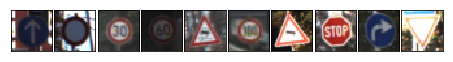

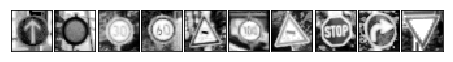

Done normalizing images
float32


In [162]:
# get random class:
random_training_images = random.sample(range(0,X_train.shape[0]), 10)
temp = preprocess(X_train[random_training_images],plot=True)


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

## Model Architecture

### Common convolution operation

In [164]:
def conv_op(x, output_depth, kernel_size = 5, stride = 1, mu = 0, sigma = 0.1, pad='SAME'):
    in_shape = x.get_shape().as_list()
    depth_in = in_shape[3]
    w = tf.Variable(tf.truncated_normal([kernel_size, kernel_size, depth_in, output_depth],mu,sigma))
    b = tf.Variable(tf.truncated_normal([output_depth],mu,sigma))
    s = [1, stride, stride, 1]
    x = tf.nn.conv2d(x, w, strides=s, padding=pad)
    x = tf.nn.bias_add(x, b)
    return x

def full_con(x, input_depth = 1, output_depth = 1, mu = 0, sigma = 0.1):
    w = tf.Variable(tf.truncated_normal([input_depth, output_depth],mu,sigma))
    b = tf.Variable(tf.truncated_normal([output_depth],mu,sigma))
    return tf.add(tf.matmul(x, w), b)

### Custom CNN architecture for traffic sign recognition

Notes from development:
Feeding forward first layer to first fully connected layer:
ConvA -> ConvB -> Flat(ConvB,ConvA) -> Flat_Out 
results in overfitting

In [165]:
def LeCNN(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    # Convolution:
    x = conv_op(x,output_depth = 18, kernel_size = 5, stride = 1, mu = mu, sigma = sigma, pad = 'SAME')
    # Activation:
    x = tf.nn.relu(x)
    # Pooling:
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    x = tf.nn.dropout(x,keep_prob)
    layer_1 = x
    
    # Convolution:
    x = conv_op(x,output_depth = 64, kernel_size = 5, stride = 1, mu = mu, sigma = sigma, pad = 'SAME')
    # Activation:
    x = tf.nn.relu(x)
    # Pooling:
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    layer_2 = x

    # Flatten. 
    x = tf.contrib.layers.flatten(x)

    
    # Layer 3: Fully Connected.
    x = full_con(x,input_depth = x.get_shape().as_list()[1], output_depth = 1024, mu = mu, sigma = sigma)
    # Activation.
    x = tf.nn.relu(x)

    
    # Layer 4: Fully Connected.
    x = full_con(x,input_depth = x.get_shape().as_list()[1], output_depth = 84, mu = mu, sigma = sigma)
    # Activation.
    x = tf.nn.relu(x)


    # Output layer:
    logits = full_con(x, x.get_shape().as_list()[1], output_depth = 42, mu = mu, sigma = sigma)
    
    return logits

## LeNet Architecture
This architecture is based on the LeNet architecture presented in the labs. For convenience, the convolution operations were implemented using common blocks.

In [166]:
def LeNet(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # SOLUTION: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    x = conv_op(x,output_depth = 6, kernel_size = 5, stride = 1, mu = mu, sigma = sigma, pad = 'SAME')
    # SOLUTION: Activation.
    x = tf.nn.relu(x)
    # SOLUTION: Pooling. Input = 28x28x6. Output = 14x14x6.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Layer 2: Convolutional. Output = 10x10x16.
    x = conv_op(x,output_depth = 16, kernel_size = 5, stride = 1, mu = mu, sigma = sigma, pad = 'SAME')
    # SOLUTION: Activation.
    x = tf.nn.relu(x)

    # SOLUTION: Pooling. Input = 10x10x16. Output = 5x5x16.
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # SOLUTION: Flatten. Input = 5x5x16. Output = 400.
    x = flatten(x)
    
    # SOLUTION: Layer 3: Fully Connected. Input = 400. Output = 120.
    x = full_con(x,input_depth = x.get_shape().as_list()[1], output_depth = 120, mu = mu, sigma = sigma)
    
    # SOLUTION: Activation.
    x = tf.nn.relu(x)

    # SOLUTION: Layer 4: Fully Connected. Input = 120. Output = 84.
    x = full_con(x,input_depth = x.get_shape().as_list()[1], output_depth = 84, mu = mu, sigma = sigma)
    
    # SOLUTION: Activation.
    x = tf.nn.relu(x)

    # SOLUTION: Layer 5: Fully Connected. Input = 84. Output = 10.
    logits = full_con(x,input_depth = x.get_shape().as_list()[1], output_depth = 42, mu = mu, sigma = sigma)
    
    return logits

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [167]:
# Preprocess data step:
# preprocess all data:
if(X_train.shape[3]!=1): 
    X_train = preprocess(X_train,plot=False)
    print('Pre-processed training data')
else:
    print('Training data already pre-processed')
if(X_test.shape[3]!=1):
    X_test = preprocess(X_test,plot=False)
    print('Pre-processed testing data')
else:
    print('Testing data already pre-processed')
    
print(X_train.shape)
print(X_test.shape)

Training data already pre-processed
Testing data already pre-processed
(39209, 32, 32, 1)
(12630, 32, 32, 1)


## setup and training + validation

Some notes:
randomly generate validation set! this is very importantant. Using the included validation set is horrible idea. Can use smaller conv-net. Need to augment data, print out log-loss and save epochs to recall and run on test.

In [168]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_train, y_train = shuffle(X_train, y_train)
X_train_local, X_valid_local, y_train_local, y_valid_local = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(X_train_local.shape)
# 2. SHUFFLE:
X_train_local, y_train_local = shuffle(X_train_local, y_train_local)
# Set up training parameters:
EPOCHS = 60
BATCH_SIZE = 256
dropout = 1

# setup tensor flow I/O with correct sizes:
x = tf.placeholder(tf.float32, (None, 32, 32, X_train.shape[3]))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 42)
keep_prob = tf.placeholder(tf.float32)

# Training:
rate = 0.00009

# logits = LeNet(x)
logits = LeCNN(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

# Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

valid_prev = -1;
valid_max = 0;
train_out = []
valid_out = []
# Model Training
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_local)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train_local, y_train_local = shuffle(X_train_local, y_train_local)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train_local[offset:end], y_train_local[offset:end]
#             sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: dropout})
        
        # HERE : NEED TO KEEP SNAPSHOT OF BEST MODEL BY MAX RESPONSE!
        validation_accuracy = evaluate(X_valid_local, y_valid_local)
        training_accuracy = evaluate(X_train_local, y_train_local)
        valid_out.append(validation_accuracy)
        train_out.append(training_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Training Accuracy = {:.3f}".format(training_accuracy))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        
        if (validation_accuracy > 0.93) and (validation_accuracy > valid_prev):
            saver.save(sess, './leCNN')
            valid_max = validation_accuracy
            print("Model saved")
        print()
        # basic early stoppage:
        if (validation_accuracy < 0.9*valid_max):
            print("Early stoppage")
            break
        valid_prev = validation_accuracy


(31367, 32, 32, 1)
Training...

EPOCH 1 ...
Training Accuracy = 0.510
Validation Accuracy = 0.502

EPOCH 2 ...
Training Accuracy = 0.711
Validation Accuracy = 0.689

EPOCH 3 ...
Training Accuracy = 0.805
Validation Accuracy = 0.772

EPOCH 4 ...
Training Accuracy = 0.853
Validation Accuracy = 0.822

EPOCH 5 ...
Training Accuracy = 0.900
Validation Accuracy = 0.872

EPOCH 6 ...
Training Accuracy = 0.912
Validation Accuracy = 0.879

EPOCH 7 ...
Training Accuracy = 0.924
Validation Accuracy = 0.892

EPOCH 8 ...
Training Accuracy = 0.936
Validation Accuracy = 0.901

EPOCH 9 ...
Training Accuracy = 0.951
Validation Accuracy = 0.918

EPOCH 10 ...
Training Accuracy = 0.962
Validation Accuracy = 0.931
Model saved

EPOCH 11 ...
Training Accuracy = 0.973
Validation Accuracy = 0.941
Model saved

EPOCH 12 ...
Training Accuracy = 0.961
Validation Accuracy = 0.928

EPOCH 13 ...
Training Accuracy = 0.965
Validation Accuracy = 0.936
Model saved

EPOCH 14 ...
Training Accuracy = 0.957
Validation Accurac

In [169]:
with tf.Session() as sess:
    saver.restore(sess, './leCNN')

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./leCNN
Test Accuracy = 0.804


In [186]:
y_web.dtype()

TypeError: 'numpy.dtype' object is not callable

Normalizing & equalizing images...


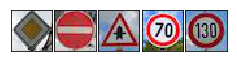

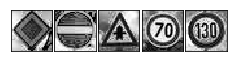

Done normalizing images


In [170]:
# Test Images
import matplotlib.image as mpimg
webImages = np.zeros((5,32,32,3), dtype = 'uint8')
k = mpimg.imread('webimages/01.jpeg')
webImages[0] = mpimg.imread('webimages/01.jpeg')
webImages[1] = mpimg.imread('webimages/02.jpeg')
webImages[2] = mpimg.imread('webimages/03.jpeg')
webImages[3] = mpimg.imread('webimages/04.jpeg')
webImages[4] = mpimg.imread('webimages/05.jpeg')

X_web = preprocess(webImages[0:5],plot=True);
y_web = np.array([12, 17,11,4,8])

class_names
class_web =np.array(['','Speed limit (130km/h)'])




---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

INFO:tensorflow:Restoring parameters from ./leCNN
Class: Priority road
	 Matching Class Priority road, Matching accuracy: 94.49%
	 Matching Class Roundabout mandatory, Matching accuracy: 2.59%
	 Matching Class Stop, Matching accuracy: 0.87%
	 Matching Class Go straight or right, Matching accuracy: 0.72%
	 Matching Class No passing, Matching accuracy: 0.57%
Class: No entry
	 Matching Class No entry, Matching accuracy: 99.98%
	 Matching Class Stop, Matching accuracy: 0.02%
	 Matching Class Turn right ahead, Matching accuracy: 0.01%
	 Matching Class Speed limit (30km/h), Matching accuracy: 0.00%
	 Matching Class Turn left ahead, Matching accuracy: 0.00%
Class: Right-of-way at the next intersection
	 Matching Class Right-of-way at the next intersection, Matching accuracy: 99.99%
	 Matching Class Beware of ice/snow, Matching accuracy: 0.00%
	 Matching Class Traffic signals, Matching accuracy: 0.00%
	 Matching Class Pedestrians, Matching accuracy: 0.00%
	 Matching Class Road narrows on the r

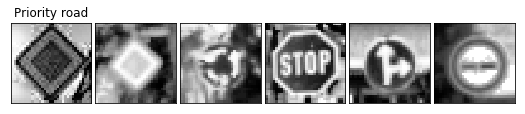

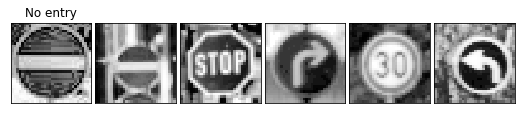

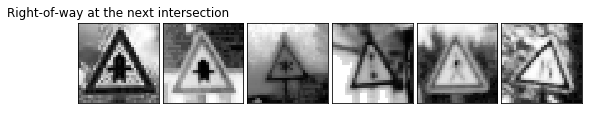

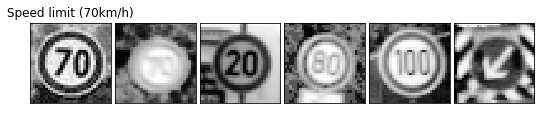

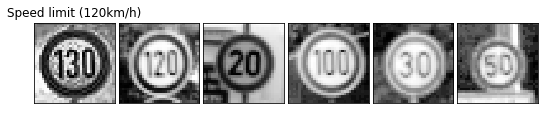

In [184]:
k_size = 5
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k_size)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, "./leCNN")
    web_logits = sess.run(softmax_logits, feed_dict={x: X_web, keep_prob: 1.0})
    web_top_k = sess.run(top_k, feed_dict={x: X_web, keep_prob: 1.0})

    for i in range(5):
        print('Class: {}'.format(class_names[y_web[i]]))
        for j in range(5):
            print('\t Matching Class {}, Matching accuracy: {:2.2f}%'.format(class_names[web_top_k[1][i][j]],100*web_top_k[0][i][j]))
            
    
    for i in range(5):
        fig = plt.figure(figsize = (7, 2))
        fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.25, wspace = 0.05)
        axis = fig.add_subplot(1, 6, 1, xticks=[], yticks=[])
        axis.imshow(X_web[i].squeeze(),cmap='gray')
        axis.set_title(class_names[y_web[i]])
        for j in range(5):
            axis = fig.add_subplot(1, 6, 2+j, xticks=[], yticks=[])
            axis.imshow(X_train[np.argwhere(y_train == web_top_k[1][i][j])[0]].squeeze())


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.